### Toymodel Train Test Evaluation

In [35]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
from mapsgan import Solver, ToyGenerator, ToyDiscriminator, data_loader
import mapsgan.experiments as experiments
from mapsgan.evaluation import Visualization
from mapsgan.utils import relative_to_abs
import matplotlib.pyplot as plt
%env CUDA_VISIBLE_DEVICES=0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=0


#### Set up dataloader, model, solver

In [50]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, trainloader = data_loader(in_len=8,
                                   out_len=12,
                                   batch_size=64,
                                   num_workers=1,
                                   path=experiment.test_dir,
                                   shuffle=False,
                                   normalize=False)

In [6]:
generator = ToyGenerator(in_len=8, out_len=12)
discriminator = ToyDiscriminator()

In [12]:
solver = Solver(generator, discriminator, 
                loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
                optims_args={'generator': {'lr': 1e-2}, 'discriminator': {'lr': 1e-2}})

#### Training

In [13]:
solver.train(trainloader, epochs = 500, checkpoint_every=10, steps = {'generator': 1, 'discriminator': 1})

G_gan: 0.568	G_norm: 0.031	G_total: 0.600	D_real: 0.650	D_fake: 0.800	D_total: 1.450	
G_gan: 0.663	G_norm: 0.059	G_total: 0.723	D_real: 0.592	D_fake: 0.797	D_total: 1.390	
G_gan: 0.685	G_norm: 0.034	G_total: 0.720	D_real: 0.672	D_fake: 0.711	D_total: 1.383	
G_gan: 0.690	G_norm: 0.032	G_total: 0.723	D_real: 0.641	D_fake: 0.696	D_total: 1.336	
G_gan: 0.688	G_norm: 0.030	G_total: 0.718	D_real: 0.664	D_fake: 0.704	D_total: 1.369	
G_gan: 0.687	G_norm: 0.046	G_total: 0.733	D_real: 0.653	D_fake: 0.707	D_total: 1.360	
G_gan: 0.677	G_norm: 0.043	G_total: 0.720	D_real: 0.634	D_fake: 0.710	D_total: 1.344	
G_gan: 0.681	G_norm: 0.048	G_total: 0.729	D_real: 0.617	D_fake: 0.710	D_total: 1.327	
G_gan: 0.690	G_norm: 0.040	G_total: 0.730	D_real: 0.650	D_fake: 0.695	D_total: 1.345	
G_gan: 0.691	G_norm: 0.033	G_total: 0.724	D_real: 0.517	D_fake: 0.696	D_total: 1.213	
G_gan: 0.674	G_norm: 0.061	G_total: 0.735	D_real: 0.595	D_fake: 0.718	D_total: 1.313	
G_gan: 0.691	G_norm: 0.041	G_total: 0.732	D_real: 0.60

#### Test

In [51]:
output = solver.test(trainloader)

#### Evaluation
visualization of predicted trajectories

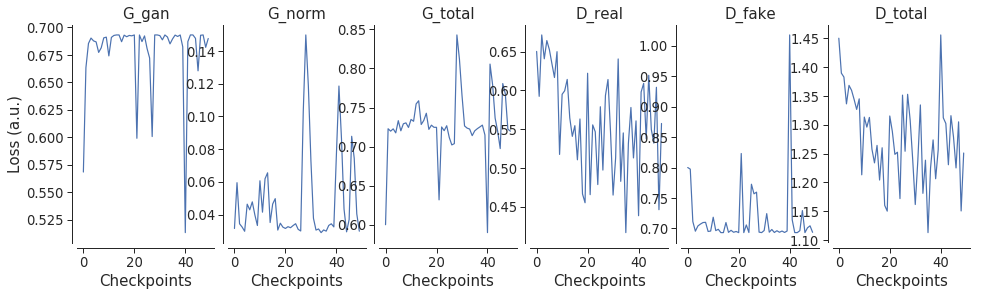

In [15]:
vis = Visualization()
vis.loss(solver.train_loss_history)

In [52]:
xy_in = output['xy_in']

In [53]:
M = torch.Tensor(xy_in[0])

In [64]:
M.shape

torch.Size([8, 2, 2])

In [61]:
X = M/M.norm(dim=0, keepdim=True)

In [62]:
np.array(M[:, 0, 0])

array([10.31,  9.57,  8.73,  7.94,  7.17,  6.47,  5.86,  5.24],
      dtype=float32)

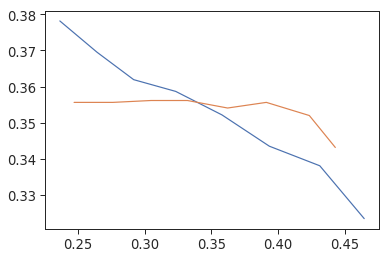

In [66]:
plt.plot(np.array(X[:, 0, 0]), np.array(X[:, 0, 1]))
plt.plot(np.array(X[:, 1, 0]), np.array(X[:, 1, 1]))

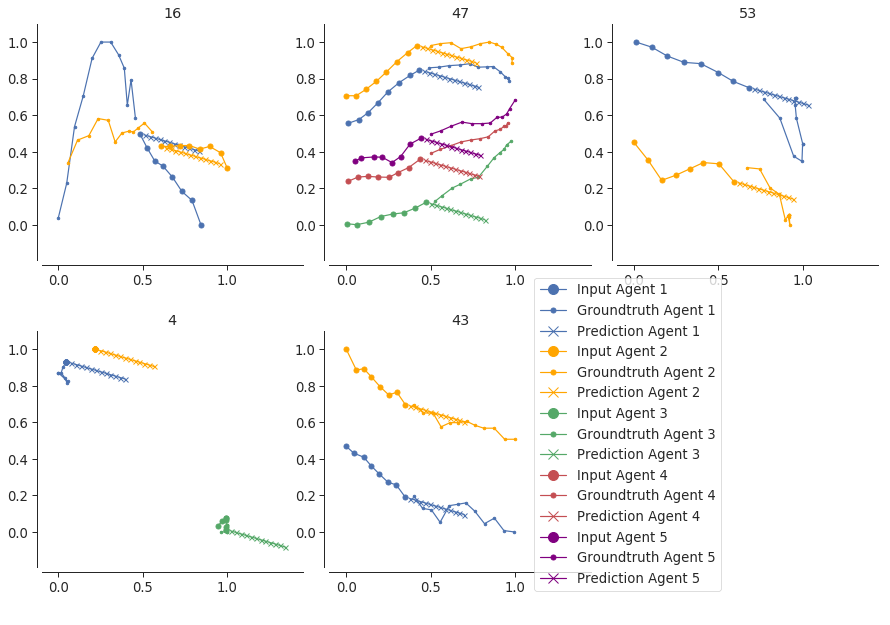

In [16]:
ll = vis.trajectories(output, scenes=[5])

### Evaluation metrics

In [17]:
xy_in = output['xy_in']
xy_out = output['xy_out']
xy_pred = output['xy_pred']

### 1. Diversity
- LPIPs distance? https://arxiv.org/pdf/1801.03924.pdf Measures (weighted) cosine distance of conv features from VGG.
**Lets see cosine distance alone:**

In [36]:
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

##### Evaluate Diversity on whole scenes

In [29]:
max_size = np.max([x.size for x in xy_out]) # number of features (flattend seq dimensions)
# zero pad and flatten, to put into (obs, feature) matrix
scenes = np.zeros([len(xy_out), max_size])
for i, scene in enumerate(xy_out):
    scenes[i, :scene.size] = scene.flatten()
scenes_pred = np.zeros([len(xy_pred), max_size])
for i, scene in enumerate(xy_pred):
    scenes_pred[i, :scene.size] = scene.flatten()

In [47]:
M = np.vstack((scenes, scenes_pred))
dissimilarity = squareform(pdist(M, metric='cosine'))

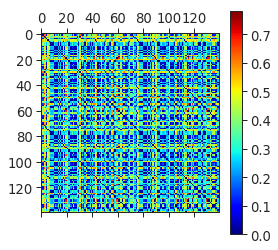

In [49]:
plt.matshow(dissimilarity, cmap = 'jet')
plt.colorbar()

In [58]:
# groundtruth
diver = pdist(scenes, metric='cosine')
# predictions
diver_pred = pdist(scenes_pred, metric='cosine')
print(f'Groundtruth: {diver.sum()}', f'Predictions: {diver_pred.sum()}')

Groundtruth: 708.503486399793 Predictions: 642.898442823863


Conclusion: diversity seems to be evident in these scores, **but** the single trajectories must be normalized since we want to evaluate diversity of the trajectories alone and not of the scenes themselves, since they are mainly conditioned on the initail 8 steps.

#### Norm trajectories

Min-max scaling:
$$\hat{X}=\frac{X-\min_{x}X}{\max_{x}X-\min_{x}X}$$
Reverse:
$$X = ({\max_{x}X-\min_{x}X})\cdot \hat{X}+\min_{x}X$$

In [333]:
def norm_sequence(seq):
    """Normalizes a seq of shape (seq_len, num_agents, num_coords)
    per trajectory.
    """
    seq = np.array(seq)
    eps = 1e-10
    seq = seq.transpose((1, 0, 2))
    normed = np.zeros_like(seq)
    for i, s in enumerate(seq):
        normed[:, i, :] = (s - s.min(axis=0)) / (s.max(axis=0) - s.min(axis=0) + eps)
    return normed

def norm_scene(scene):
    """Normalize all sequences within a scene.
    
    Args:
        scene (list): List of sequences of shape expected by norm_sequence.
    """
    normed = []
    for seq in scene:
        normed.append(norm_sequence(seq))
    return normed

In [15]:
def norm_sequence(seq):
    """Normalizes all trajectories in a sequence independently using
    min-max normalization.

    Args:
        seq (tensor): Tensor of shape (num_agents, num_coords, seq_len)

    Returns:
        tensor: Tensor with normalized coordinates of the same shape as seq.
    """
    eps = 1e-10
    normed = torch.zeros_like(seq)
    seq_min = seq.min(dim=0, keepdim=True)[0].min(dim=2, keepdim=True)[0]
    seq_max = seq.max(dim=0, keepdim=True)[0].max(dim=2, keepdim=True)[0]
    for i, s in enumerate(seq):
        normed[i] = (s - seq_min) / (seq_max - seq_min + eps)
    return normed

In [16]:
norm_sequence(xy_in.permute(1, 2, 0))[0]

NameError: name 'xy_in' is not defined

In [113]:
q = iter(trainloader)

In [114]:
x = next(q)

In [115]:
xy_in = x['xy_in']

In [116]:
seq_start_end = x['seq_start_end']

In [117]:
start, end = seq_start_end[0]

In [122]:
a = xy_in[start:end]

In [143]:
a - a.min(dim=0, keepdim=True)[0].min(dim=0, keepdim=True)[0]

tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         ...,
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         ...,
         [0.8600, 0.4900],
         [0.3100, 0.0000],
         [0.5500, 0.0200]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         ...,
         [1.6800, 0.9500],
         [0.9400, 0.1200],
         [1.1700, 0.0300]]])

In [154]:
a - a.min(dim=0, keepdim=True)[0].min(dim=1, keepdim=True)[0]

tensor([[[13.6000,  8.7000],
         [14.6400,  9.1000],
         [19.3300,  3.3400],
         ...,
         [ 4.5100,  0.7900],
         [ 3.1800,  7.0000],
         [ 2.7700,  7.7900]],

        [[13.6000,  8.7000],
         [14.6400,  9.1000],
         [19.3300,  3.3400],
         ...,
         [ 5.3700,  1.2800],
         [ 3.4900,  7.0000],
         [ 3.3200,  7.8100]],

        [[13.6000,  8.7000],
         [14.6400,  9.1000],
         [19.3300,  3.3400],
         ...,
         [ 6.1900,  1.7400],
         [ 4.1200,  7.1200],
         [ 3.9400,  7.8200]]])

In [413]:
eps = 1e-10
seq = dataset.obs_traj
normed = torch.zeros_like(seq)
for i, s in enumerate(seq):
    normed[i] = (s - s.min(dim=0)[0]) / (s.max(dim=0)[0] - s.min(dim=0)[0] + eps)

In [435]:
x = xy_in[0][:, 0, :]

In [438]:
x - x.min(axis=0)

array([[5.0700006 , 0.        ],
       [4.33      , 0.26999998],
       [3.4899998 , 0.37000036],
       [2.7000003 , 0.5300002 ],
       [1.9300003 , 0.6500001 ],
       [1.23      , 0.71000004],
       [0.62000036, 0.8500004 ],
       [0.        , 1.0100002 ]], dtype=float32)

In [423]:
seq[0] - seq[0].min(dim=1, keepdim=True)[0]

tensor([[5.0700, 4.3300, 3.4900, 2.7000, 1.9300, 1.2300, 0.6200, 0.0000],
        [0.0000, 0.2700, 0.3700, 0.5300, 0.6500, 0.7100, 0.8500, 1.0100]])

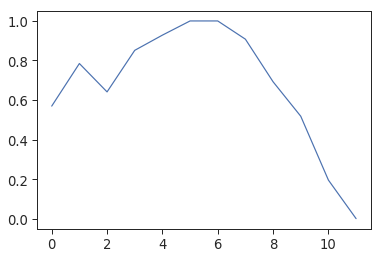

In [400]:
plt.plot(norm_sequence(xy_out[0])[:, 0, 1])

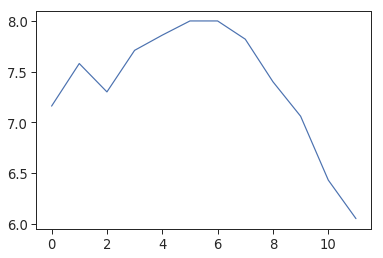

In [401]:
plt.plot(xy_out[0][:, 0, 1])

In [344]:
dataset.obs_traj.permute(2, 0, 1)

torch.Size([8, 181, 2])

In [389]:
torch.zeros_like(x).min(dim = 0)[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
torch.zeros_like(x).min

In [370]:
def displacement(seq):
    disp = torch.zeros_like(seq)
    for i, s in enumerate(seq):
        disp[i, :, 1:] = s[:, 1:] - s[:, :-1]
    return disp

In [365]:
disp = torch.zeros_like(dataset.obs_traj)

In [369]:
disp[0, :, 1:].shape

torch.Size([2, 7])

In [380]:
displacement(dataset.obs_traj), dataset.obs_traj_rel

(tensor([[[ 0.0000, -0.7400, -0.8400,  ..., -0.7000, -0.6100, -0.6200],
          [ 0.0000,  0.2700,  0.1000,  ...,  0.0600,  0.1400,  0.1600]],
 
         [[ 0.0000, -0.5500, -0.9100,  ..., -0.7700, -0.8100, -0.8200],
          [ 0.0000,  0.1700,  0.0700,  ...,  0.0000, -0.0100,  0.0000]],
 
         [[ 0.0000, -0.9700, -0.5800,  ..., -0.3400, -0.6700, -0.8300],
          [ 0.0000, -0.1600, -0.0600,  ..., -0.1200, -0.1000, -0.3300]],
 
         ...,
 
         [[ 0.0000,  0.4600,  0.4600,  ...,  0.4300,  0.4800,  0.4200],
          [ 0.0000, -0.0900,  0.0000,  ..., -0.1000,  0.0300,  0.0000]],
 
         [[ 0.0000,  0.4600,  0.4600,  ...,  0.4900,  0.4600,  0.4300],
          [ 0.0000,  0.0100, -0.0900,  ...,  0.1200,  0.0100,  0.0100]],
 
         [[ 0.0000,  0.4600,  0.4900,  ...,  0.4800,  0.4200,  0.4700],
          [ 0.0000,  0.0000, -0.0600,  ...,  0.0300,  0.0000,  0.0100]]]),
 tensor([[[ 0.0000, -0.7400, -0.8400,  ..., -0.7000, -0.6100, -0.6200],
          [ 0.0000,  0.2700,  

In [349]:
x = dataset.obs_traj[0]

In [357]:
dataset.obs_traj_rel[0]

tensor([[ 0.0000, -0.7400, -0.8400, -0.7900, -0.7700, -0.7000, -0.6100, -0.6200],
        [ 0.0000,  0.2700,  0.1000,  0.1600,  0.1200,  0.0600,  0.1400,  0.1600]])

In [355]:
x

tensor([[10.3100,  9.5700,  8.7300,  7.9400,  7.1700,  6.4700,  5.8600,  5.2400],
        [ 5.9700,  6.2400,  6.3400,  6.5000,  6.6200,  6.6800,  6.8200,  6.9800]])

In [354]:
x[:, 1:] - y[:, :-1]

tensor([[-0.7400, -0.8400, -0.7900, -0.7700, -0.7000, -0.6100, -0.6200],
        [ 0.2700,  0.1000,  0.1600,  0.1200,  0.0600,  0.1400,  0.1600]])

In [382]:
norm_sequence(dataset.obs_traj.permute(2, 0, 1)).shape

(8, 181, 2)

In [102]:
normed_output ={'xy_in': norm_scene(output['xy_in']),
              'xy_out': norm_scene(output['xy_out']),
              'xy_pred': norm_scene(output['xy_pred'])}

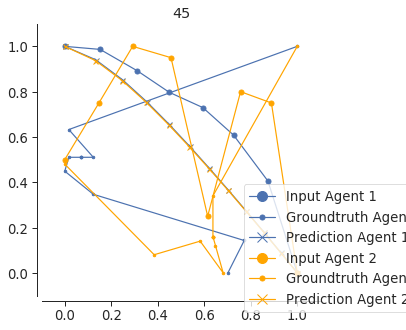

In [113]:
vis.trajectories(normed_output, scenes=[1])

#### Diversity with normed trajectories

In [115]:
xy_out = normed_output['xy_out']
xy_pred = normed_output['xy_pred']
max_size = np.max([x.size for x in xy_out]) # number of features (flattend seq dimensions)
# zero pad and flatten, to put into (obs, feature) matrix
scenes = np.zeros([len(xy_out), max_size])
for i, scene in enumerate(xy_out):
    scenes[i, :scene.size] = scene.flatten()
scenes_pred = np.zeros([len(xy_pred), max_size])
for i, scene in enumerate(xy_pred):
    scenes_pred[i, :scene.size] = scene.flatten()

In [188]:
M = np.vstack((scenes, scenes_pred))
dissimilarity = squareform(pdist(M, metric='cosine'))

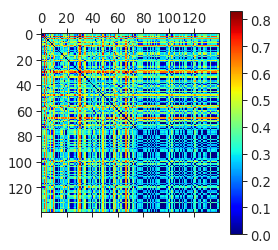

In [189]:
plt.matshow(dissimilarity, cmap = 'jet')
plt.colorbar()

#### Now, we nicely see how the generated output (right bottom square) is less diverse than the groundtruth output.

In [118]:
# groundtruth
diver = pdist(scenes, metric='cosine')
# predictions
diver_pred = pdist(scenes_pred, metric='cosine')
print(f'Groundtruth: {diver.sum()}', f'Predictions: {diver_pred.sum()}')

Groundtruth: 875.4802928263806 Predictions: 461.78947794410806


#### As tensors

In [146]:
cos = nn.CosineSimilarity(dim=0)

In [150]:
1 - cos(torch.Tensor(xy_out[0][:, 0, :]).flatten(), torch.Tensor(xy_out[0][:, 1, :]).flatten())

tensor(0.0221)

In [154]:
torch.Tensor(xy_out[0]).transpose(1, 0).shape

torch.Size([2, 12, 2])

In [315]:
def cos_sequence(seq):
    """Computes the cosine distance of seq of shape (seq_len, num_agents, num_coords)
    per trajectory.
    """
    cos = nn.CosineSimilarity(dim=0)
    eps = 1e-10
    num_agents = seq.shape[1]
    distance = torch.zeros([num_agents, num_agents])
    seq = seq.transpose(1, 0)
    ind = np.triu_indices(num_agents, k=1)
    for i, s1 in enumerate(seq):
        for j, s2 in enumerate(seq):
            distance[i, j] = 1 - cos(s1.flatten(), s2.flatten())
    return distance[ind]

def cos_scene(scene):
    """Summed cosine distance for all sequences within a scene.
    
    Args:
        scene (list): List of sequences of shape expected by cos_sequence.
    """
    distances = []
    for seq in scene:
        distances.append(cos_sequence(seq).sum())
    return sum(distances)

In [316]:
xy_out_T = [torch.Tensor(x) for x in xy_out]

In [317]:
distance_scene(xy_out_T)

tensor(37.0470)

In [321]:
xy_pred_T = [torch.Tensor(x) for x in xy_pred]
distance_scene(xy_pred_T)

tensor(4.9163)

In [322]:
distance_scene(xy_pred_T)/distance_scene(xy_out_T)

tensor(0.1327)

# 2. Realism

### Idea 1: Given an r² value, fit linear splines on trajectories and count the number of knots (or splines) needed for such accurate interpolation. Compare the total number of knots. True trajectories should require more knots than artificial trajectories.

- But, is this a measure for diversity or realism?

In [25]:
from scipy.interpolate import UnivariateSpline

In [245]:
x = xy_out[0][:, 0, 0]
y = xy_out[0][:, 0, 1]

In [246]:
spl = UnivariateSpline(x, y, k=1, s=0.05)

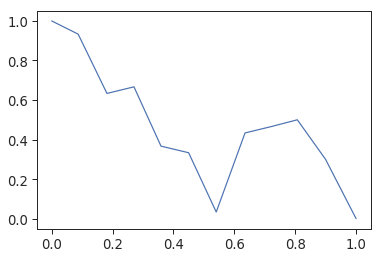

In [260]:
plt.plot(x, y)

In [26]:
def num_knots(seqs):
    num_agents = seqs.shape[1]
    knots = np.zeros(num_agents)
    seqs = seqs.transpose((1, 0, 2))
    for i, seq in enumerate(seqs):
        y = seq[:, 1]
        x = np.linspace(0, 1, y.size)
        spl = UnivariateSpline(x, y, k=1, s=0.05)
        knots[i] = spl.get_knots().size
    return knots

def knots_scene(scene):
    knots = 0
    for seq in scene:
        knots += num_knots(seq).sum()
    return knots

In [31]:
xy_pred = output['xy_pred']
knots_scene(xy_pred)

389.0

### Idea 2: Euclidean distances. Real trajectories should not deviate much from groundtruth trajectories.

In [ ]:
def dist_seq(seqs):
    num_agents = seqs.shape[1]
    distance = np.zeros(num_agents)
    seqs = seqs.transpose((1, 0, 2))
    for i, seq in enumerate(seqs):
        y = seq[:, 1]
        x = np.linspace(0, 1, y.size)
        spl = UnivariateSpline(x, y, k=1, s=0.05)
        knots[i] = spl.get_knots().size
    return knots

def knots_scene(scene):
    knots = 0
    for seq in scene:
        knots += num_knots(seq).sum()
    return knots

In [270]:
mse = nn.MSELoss()

In [276]:
mse(torch.Tensor(xy_out[0]), torch.Tensor(xy_pred[0]))

tensor(0.0186)

# Conclusions: Normalizing the dataset is not feasible so far. Normalizing the predictions before evaluating similarity might make sense tho.
Next steps:
- continue implementing cosine similarity, knots, collisions into evaluation
- implement proper checkpoint/saving as solver.save
- loading as solver.load
- write script to train
- train toymodel on gcloud with real train data